In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import myhelper as mhp
import myconfig as cfg

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              ExtraTreesClassifier)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (StratifiedKFold,
                                    GridSearchCV,
                                    RandomizedSearchCV,
                                    cross_val_score)

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

import warnings
warnings.filterwarnings('ignore')

## loading data

In [2]:
# load data
df = pd.read_csv('data/train.csv').pipe(mhp.data_prep)
perf = pd.read_csv('data/perf-results.csv')

df.shape, perf.shape

((5500, 61), (280, 9))

## Quick model performance analysis

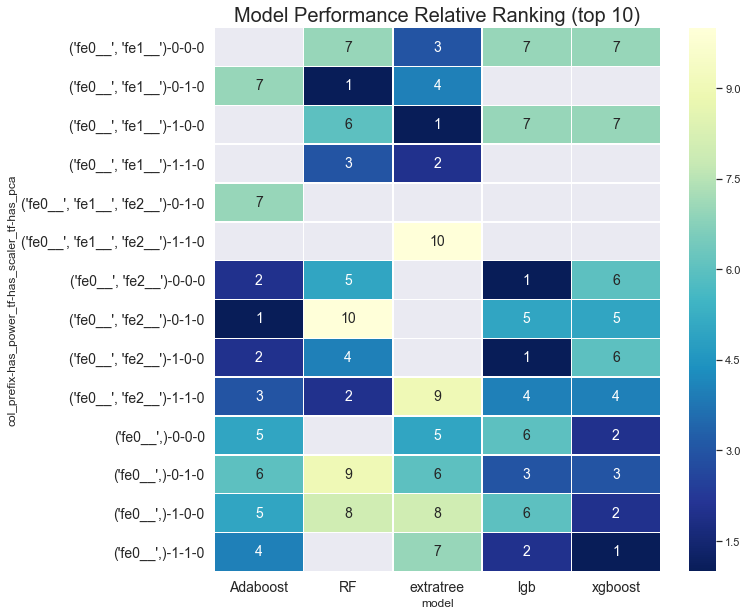

In [165]:
top_n = 10
agg_cols = ['col_prefix', 'has_power_tf', 'has_scaler_tf', 'has_pca']

agg = perf \
        .groupby(agg_cols) \
        .mean() \
        .stack() \
        .rename_axis(index={None: 'model'}) \
        .groupby(level=-1) \
        .nlargest(top_n) \
        .reset_index(level=0, drop=True) \
        .groupby(level=-1) \
        .apply(lambda x: x.rank(method='dense', ascending=False)) \
        .unstack(level='model')

plt.figure(figsize=(10,10));
sns.set()
g = sns.heatmap(agg, cmap='YlGnBu_r', annot=True, square=False, linewidths=.5,
                annot_kws={'fontsize':14})
g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=14)
g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=14)  
plt.title('Model Performance Relative Ranking (top {})'.format(top_n), fontsize = 20)
plt.show();

From the above heapmap the following configuration seem to be a good candidate to hyper-tune<br>
<b>config 1:<br>
&emsp;. fe__0 with column prefix<br>
&emsp;. power transformation<br>
&emsp;. standardization<br>
<br>
<!-- <b>config 2:<br>
&emsp;. fe__0 and fe__2 with column prefix<br>
&emsp;. power transformation<br>
&emsp;. standardization<br> -->

## baseline pred submission
&emsp;. no data transformation<br>
&emsp;. no feature engineering<br>
&emsp;. default model values<br>
&emsp;. no hypertuning<br>

In [236]:
X = pd.read_csv('data/train.csv').pipe(mhp.data_prep)
X, y = df.drop(columns=cfg.TARGET_COL), df[cfg.TARGET_COL]

X_test = pd.read_csv('data/test.csv').pipe(mhp.data_prep)

model = LGBMClassifier()
fit = model.fit(X, y)
model.predict_proba(X_test)[:, 1]

cols = ['Id', 'Choice']
X_test['Choice'] = preds
X_test['Id'] = X_test.index+1
X_test[cols].to_csv('data/preds-baseline.csv', index=False)

## hyper-tuning using random gread search + nested-cross validation

### preparing pipeline

In [238]:
# data prep
X, y = df.drop(columns=cfg.TARGET_COL), df[cfg.TARGET_COL]

# restrict with column prefix fe0__
X = X[mhp.extract_column_names(X, '^fe0__')]
scale_cols = mhp.extract_column_names(X, '^(?!{})'.format('fe2__'))

# sampling
# X, y = mhp.sampling(X, y, cfg.SAMPLE_SIZE, cfg.SEED)

# add power and standardization transformations to the pipeline definition
steps = []
steps.append(('data_tf',
              ColumnTransformer(transformers=[
                ('power_tf', PowerTransformer(method='yeo-johnson', standardize=False), scale_cols),
                ('scaler_tf', StandardScaler(), scale_cols)
              ], remainder='passthrough')))

# add model to pipeline definition
model = LGBMClassifier()
steps.append(('clf', model))

# create pipeline
pipeline = Pipeline(steps)


In [151]:
# pipeline.get_params().keys()

### evaluation of randomgrid search + nested-cross validation

In [19]:
# config = {}
# config['lgb_1'] = {'model': None,
#             'pipeline_steps': None,
#             'search_space_sklearn': None, 
#             'search_space_hyperopt': None,
#             'best_params_sklearn': None,
#             'best+params_hyperop': None
#            }


In [240]:
# space['lgb'] = {'clf__n_estimators': np.arange(10, 110, 10),
#                 'clf__num_leaves': (2, 5), 
#                 'clf__min_data_in_leaf': (1, 10),  
#                 'clf__learning_rate': np.arange(0.005, 0.3, 0.01),
#                 'clf__min_sum_hessian_in_leaf': (0.1, 0.5),    
#                 'clf__feature_fraction': (0.2, 0.5),
#                 'clf__lambda_l1': (0, 1), 
#                 'clf__lambda_l2': (0, 1), 
#                 'clf__min_gain_to_split': (0.1, 1.0),
#                 'clf__max_depth': np.arange(2, 10, 1)
#                }

# space['xgboost'] = {'clf__n_estimators': np.arange(20, 205, 5),
#                     'clf__max_depth': range(5, 30, 1),
#                     'clf__learning_rate': np.arange(0.01, 0.5, 0.01),
#                     'clf__gamma': np.arange(0, 0.50, 0.01),
#                     'clf__min_child_weight': range(1, 10, 1),
#                     'clf__subsample': np.arange(0.1, 1, 0.01),
#                     'clf__colsample_bytree': np.arange(0.1, 1.0, 0.01)
#                    }

# space['RF'] = {'clf__n_estimators': np.arange(20, 205, 5),
#                'clf__max_depth': range(5, 30, 1),
#                'clf__max_features' : ['sqrt','log2',0.2,0.5,0.8],
#                'clf__min_samples_leaf': range(1, 10, 1),
#                'clf__criterion': ['gini','entropy'],
#                'clf__min_samples_split' : range[5, 20, 5]
#               }

# space['Adaboost'] = {'clf__n_estimators': np.arange(20, 205, 5),
#                      'clf__learning_rate': range(5, 30, 1)
#                     }

# space['extratree'] = {'clf__n_estimators': np.arange(20, 205, 5),
#                       'clf__max_depth': range(5, 30, 1),
#                       'clf__max_features' : ['sqrt','log2',0.2,0.5,0.8],
#                       'clf__min_samples_leaf': range(1, 10, 1),
#                       'clf__criterion': ['gini','entropy'],
#                       'clf__min_samples_split' : range[5, 20, 5]
#                      }

# space['extratree'] = {'clf__n_estimators': np.arange(20, 205, 5),
#                       'clf__max_depth': range(5, 30, 1),
#                       'clf__max_features' : ['sqrt','log2',0.2,0.5,0.8],
#                       'clf__min_samples_leaf': range(1, 10, 1),
#                       'clf__criterion': ['gini','entropy'],
#                       'clf__min_samples_split' : range[5, 20, 5]
#                      }


In [153]:
# outer cross-validation
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.SEED)

# inner cross-validation
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.SEED)

# search = GridSearchCV(model, space, scoring='roc_auc', n_jobs=4, cv=cv_inner, refit=True)
search = RandomizedSearchCV(pipeline,
                            space,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=cv_inner,
                            n_iter=20,
                            refit=True)

# evaluate the nested cross-validation
scores = cross_val_score(search, X, y, scoring='roc_auc', cv=cv_outer, n_jobs=-1)
print(np.mean(scores), np.std(scores))
print(scores)

0.8724774381975011 0.008273751525117733
[0.88064153 0.86051918 0.86472388 0.87654401 0.8799586 ]


### hyper-tuning using best parameters of randomgrid search + nested-cross validation

In [241]:
verbose = 1
# store resutls
outer_results = list()
# outer cross-validation
# cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=cfg.SEED)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.SEED)
# inner cross-validation
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.SEED)

for i, (train_ix, test_ix) in enumerate(cv_outer.split(X, y)):
    # split data
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    # define search
    search = RandomizedSearchCV(pipeline, space, scoring='roc_auc', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    score = roc_auc_score(y_test, yhat)
    # store the result
    res_ = {'cvo_k': i,
            'cvo_score': score,
            'cvi_best_score': result.best_score_,
            'cvi_best_params': result.best_params_}
    outer_results.append(res_)
    # outpu progress
    if verbose:
        print('cvo_k: {}, cvo_score: {},cvi_best_score: {}, cvi_best_params: {}\n'
              .format(i, score, result.best_score_, result.best_params_))

outer_results = pd.DataFrame.from_dict(outer_results)
# ovearll model perf
print('mean: {}, std: {}'.format(outer_results.cvo_score.mean(), outer_results.cvo_score.std()))

cvo_k: 0, cvo_score: 0.7893849206349206,cvi_best_score: 0.8680709902883855, cvi_best_params: {'clf__num_leaves': 2, 'clf__n_estimators': 100, 'clf__min_sum_hessian_in_leaf': 0.5, 'clf__min_gain_to_split': 1.0, 'clf__min_data_in_leaf': 1, 'clf__max_depth': 9, 'clf__learning_rate': 0.285, 'clf__lambda_l2': 1, 'clf__lambda_l1': 0, 'clf__feature_fraction': 0.5}

cvo_k: 1, cvo_score: 0.7753637566137567,cvi_best_score: 0.8753328740169352, cvi_best_params: {'clf__num_leaves': 5, 'clf__n_estimators': 100, 'clf__min_sum_hessian_in_leaf': 0.1, 'clf__min_gain_to_split': 1.0, 'clf__min_data_in_leaf': 10, 'clf__max_depth': 3, 'clf__learning_rate': 0.12499999999999999, 'clf__lambda_l2': 1, 'clf__lambda_l1': 1, 'clf__feature_fraction': 0.5}

cvo_k: 2, cvo_score: 0.7852513227513227,cvi_best_score: 0.8717952188443675, cvi_best_params: {'clf__num_leaves': 5, 'clf__n_estimators': 80, 'clf__min_sum_hessian_in_leaf': 0.1, 'clf__min_gain_to_split': 1.0, 'clf__min_data_in_leaf': 10, 'clf__max_depth': 6, 'clf

In [242]:
outer_results.nlargest(1, columns='cvo_score').values

array([[4, 0.7920986576448761, 0.8707541152717161,
        {'clf__num_leaves': 5, 'clf__n_estimators': 60, 'clf__min_sum_hessian_in_leaf': 0.1, 'clf__min_gain_to_split': 0.1, 'clf__min_data_in_leaf': 10, 'clf__max_depth': 8, 'clf__learning_rate': 0.145, 'clf__lambda_l2': 1, 'clf__lambda_l1': 1, 'clf__feature_fraction': 0.2}]],
      dtype=object)

In [243]:
outer_results.nlargest(1, columns='cvi_best_score').values

array([[1, 0.7753637566137567, 0.8753328740169352,
        {'clf__num_leaves': 5, 'clf__n_estimators': 100, 'clf__min_sum_hessian_in_leaf': 0.1, 'clf__min_gain_to_split': 1.0, 'clf__min_data_in_leaf': 10, 'clf__max_depth': 3, 'clf__learning_rate': 0.12499999999999999, 'clf__lambda_l2': 1, 'clf__lambda_l1': 1, 'clf__feature_fraction': 0.5}]],
      dtype=object)

### random grid search pred submission

In [244]:
X = pd.read_csv('data/train.csv').pipe(mhp.data_prep)
X_test = pd.read_csv('data/test.csv').pipe(mhp.data_prep)

# restrict with column prefix fe0__
X, y = df.drop(columns=cfg.TARGET_COL), df[cfg.TARGET_COL]
cols = mhp.extract_column_names(X, '^fe0__')
X = X[cols]
X_test = X_test[cols]
scale_cols = mhp.extract_column_names(X, '^(?!{})'.format('fe2__'))

# get best parameters from grid search+nested cv
best_params = outer_results.nlargest(1, columns='cvi_best_score').cvi_best_params.values[0]
# retrain pipeline on full dataset using best parameters
pipeline_final = Pipeline(steps)
pipeline_final.set_params(**best_params)
fit = pipeline_final.fit(X, y)
preds = pipeline_final.predict_proba(X_test)[:, 1]

cols = ['Id', 'Choice']
X_test['Choice'] = preds
X_test['Id'] = X_test.index+1
X_test[cols].to_csv('data/preds-random-grid-search-nestted-cv.csv', index=False)

## hyper-tuning using Hyperopt
Hyperopt: Distributed Asynchronous Hyper-parameter Optimization<br>
    http://hyperopt.github.io/hyperopt/

### preparing pipeline

In [20]:
# data prep
X = pd.read_csv('data/train.csv').pipe(mhp.data_prep)
X_test = pd.read_csv('data/test.csv').pipe(mhp.data_prep)

X, y = df.drop(columns=cfg.TARGET_COL), df[cfg.TARGET_COL]

# restrict with column prefix fe0__
# regex = '^(fe0__|fe2__)'
regex = '^fe0__'
cols = mhp.extract_column_names(X, regex)
X = X[cols]
X_test = X_test[cols]
scale_cols = mhp.extract_column_names(X, '^(?!{})'.format('fe2__'))

# sampling
# X, y = mhp.sampling(X, y, cfg.SAMPLE_SIZE, cfg.SEED)

# add power and standardization transformations to the pipeline definition
steps = []
steps.append(('data_tf',
              ColumnTransformer(transformers=[
                ('power_tf', PowerTransformer(method='yeo-johnson', standardize=False), scale_cols),
                ('scaler_tf', StandardScaler(), scale_cols)
              ], remainder='passthrough')))

# add model to pipeline definition
model = LGBMClassifier()
steps.append(('clf', model))

# create pipeline
pipeline = Pipeline(steps)


### create objective function to minimize (-auc)

In [14]:
def objective(params):
    # define stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    # set pipeline params
    pipeline.set_params(**params)
    # score pipeline
    score = -cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv).mean()
    # return result
    return {'loss': score, 'status': STATUS_OK }

In [15]:
# Define the hyperparameter configuration space
space = {
        'clf__max_depth': hp.choice('clf__max_depth', range(5, 51)),
        'clf__min_child_weight': hp.quniform('clf__min_child_weight', 0.0 , 0.2, 0.01),
        'clf__learning_rate': hp.quniform('clf__learning_rate', 0.005, 0.3, 0.01),
        'clf__subsample': hp.quniform('clf__subsample', 0.1, 1.0, 0.05),
        'clf__colsample_bylevel': hp.quniform('clf__colsample_bylevel', 0.1, 1.0, 0.05),
        'clf__colsample_bytree': hp.quniform('clf__colsample_bytree', 0.1, 1.0, 0.05),
        'clf__n_estimators': hp.choice('clf__n_estimators', range(10, 101, 1))
        }
trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

space_eval(space, best)


100%|██████████| 30/30 [00:22<00:00,  1.34trial/s, best loss: -0.8741682164371717]


{'clf__colsample_bylevel': 0.55,
 'clf__colsample_bytree': 0.1,
 'clf__learning_rate': 0.09,
 'clf__max_depth': 31,
 'clf__min_child_weight': 0.19,
 'clf__n_estimators': 98,
 'clf__subsample': 0.4}

### final pipeline perf verification using the best parameters

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
# set pipeline params
pipeline.set_params(**space_eval(space, best))
# score pipeline
score = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)

score.mean(), score.std()

(0.8741682164371717, 0.007220469869029241)

### Hyperopt pred submission

In [17]:
# set pipeline with best found parameters
pipeline.set_params(**space_eval(space, best))
# retrain pipeline on full dataset using best parameters
fit = pipeline.fit(X, y)
# make predictions
preds = pipeline.predict_proba(X_test)[:, 1]

cols = ['Id', 'Choice']
X_test['Choice'] = preds
X_test['Id'] = X_test.index+1
X_test[cols].to_csv('data/preds-hyperopt.csv', index=False)

## conclusion

Due to the time constraint I limited the submission to LightGBM giving me the following results:<br>
&emsp;. private Score: <b>0.86727</b> (30ish place)<br>
&emsp;. public Score: <b>0.87001</b> (10th place)<br><br>

With extra time, I will:<br>
&emsp;. proceed hyper-tunining in the same manner using XGBoost, RF, AdaBoost, ExtraTree<br>
&emsp;. stack the best tuned models (for each model family)<br>
